In [118]:
# I use Google Colab for this task, therefore file directories are designed for this.

# Final project: Predict Future Sales

## Step 1: import libraries and load data

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from itertools import product
import time
import io
from sklearn.linear_model import Ridge, RidgeCV

In [3]:
from google.colab import files
uploaded = files.upload()

Saving item_categories.csv to item_categories.csv
Saving items.csv to items.csv
Saving sales_train_v2.csv to sales_train_v2.csv
Saving shops.csv to shops.csv
Saving test.csv to test.csv


In [0]:
item_categories = pd.read_csv(io.BytesIO(uploaded['item_categories.csv']))
items = pd.read_csv(io.BytesIO(uploaded['items.csv']))
sales_train = pd.read_csv(io.BytesIO(uploaded['sales_train_v2.csv']))
shops = pd.read_csv(io.BytesIO(uploaded['shops.csv']))
test = pd.read_csv(io.BytesIO(uploaded['test.csv']))

## Step 2: EDA

### Let's look at the shape of our DataFrames

In [5]:
print('sales_train shape: ', sales_train.shape)

sales_train shape:  (2935849, 6)


In [6]:
print('items: ', items.shape)

items:  (22170, 3)


In [7]:
print('item_categories shape: ', item_categories.shape)

item_categories shape:  (84, 2)


In [8]:
print('shops shape: ', shops.shape)

shops shape:  (60, 2)


In [9]:
print('test shape: ', test.shape)

test shape:  (214200, 3)


### First rows of data

In [10]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [11]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [12]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [13]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


You may notice that the name of the shops consists of two parts. The first is the name of the city, and the second is the name of the shop itself.
Moreover, you can see that the name of one city is presented in two versions (Якутск and !Якутск). For this reason, in the future we will have to replace the name of this city with the same thing.

As you can see, table sales_train contains general information about sales by the day, but we need information for each store by month, since we need to make predictions by month. For this purpose in the future we will group our data.

Also, we may need to connect the dataframe sales_train and the other tables in order to get more detailed information about the stores and products that they sold.

You can also notice that the data is a time series, therefore, it is necessary to study the changes taking into account the time.

## Graphs and data visualization

### Time series

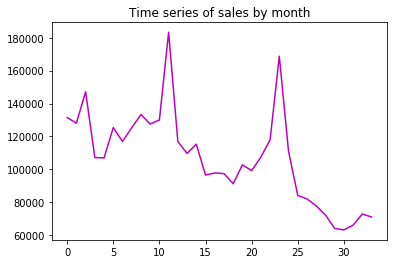

In [14]:
plt.title('Time series of sales by month')
plt.plot(sales_train.groupby('date_block_num')['item_cnt_day'].sum(), 'm')

You may notice that the number of sales varies greatly depending on the month. This may depend on both external factors and the data structure. For example, not all sales for a month may be reflected there, therefore, during training, we must create all possible combinations of shops and items in order to more accurately reflect the nature of the formation of sales.

### Sales by categories

(array([74.,  1.,  4.,  1.,  1.,  1.,  0.,  1.,  0.,  1.]),
 array([1.00000e+00, 6.34180e+04, 1.26835e+05, 1.90252e+05, 2.53669e+05,
        3.17086e+05, 3.80503e+05, 4.43920e+05, 5.07337e+05, 5.70754e+05,
        6.34171e+05]),
 <a list of 10 Patch objects>)

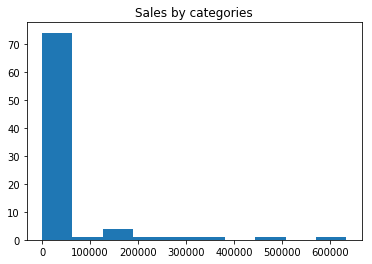

In [15]:
plt.title('Sales by categories')
sales_categories = pd.merge(sales_train, items, on='item_id')
plt.hist(sales_categories.groupby('item_category_id')['item_cnt_day'].sum())

Sales in most categories are small, but the number of sales for some of them is very large.

### Product Price Analysis

An analysis of the price of items can be useful in order to find outliers. In this situation, this is possible, since some price restrictions can be defined.

From this histogram, you can determine that most prices are from 0 to 50,000, but there are some outliers that the following graph will help us see.

(array([2.935632e+06, 2.160000e+02, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([-1.000000e+00,  3.079710e+04,  6.159520e+04,  9.239330e+04,
         1.231914e+05,  1.539895e+05,  1.847876e+05,  2.155857e+05,
         2.463838e+05,  2.771819e+05,  3.079800e+05]),
 <a list of 10 Patch objects>)

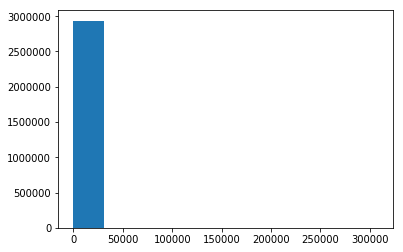

In [16]:
plt.hist(sales_train['item_price'])

This graph shows that there is one outlier with a price of 300,000. In the formation of training data, we will need to remove it.

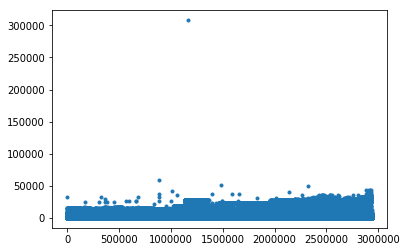

In [17]:
plt.plot(sales_train['item_price'], '.')

(array([2.900052e+06, 1.444500e+04, 1.069600e+04, 3.691000e+03,
        4.228000e+03, 2.283000e+03, 4.070000e+02, 3.300000e+01,
        1.000000e+01, 1.000000e+00]),
 array([-1.00000e+00,  4.97730e+03,  9.95560e+03,  1.49339e+04,
         1.99122e+04,  2.48905e+04,  2.98688e+04,  3.48471e+04,
         3.98254e+04,  4.48037e+04,  4.97820e+04]),
 <a list of 10 Patch objects>)

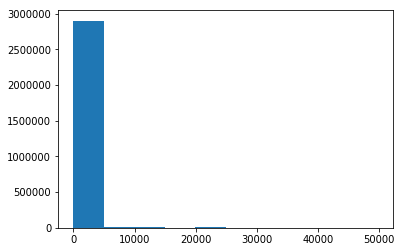

In [18]:
plt.hist(sales_train[sales_train['item_price'] < 50000]['item_price'])

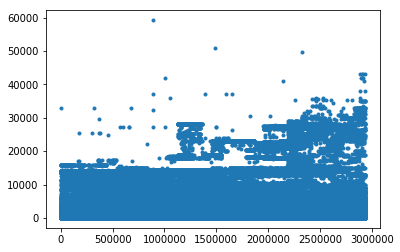

In [19]:
plt.plot(sales_train[sales_train['item_price'] < 100000]['item_price'], '.')

The data contains a negative price, which is impossible.

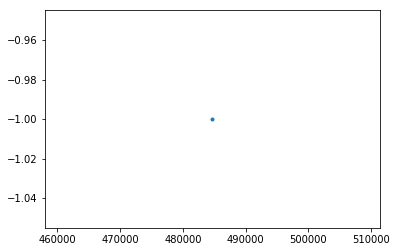

In [20]:
plt.plot(sales_train[sales_train['item_price'] < 0]['item_price'], '.')

### Analysis of the number of sales per day

According to the following graphs, you can see that most of the sales are up to 1000, so in the next we will consider them.

(array([2.93581e+06, 2.40000e+01, 1.10000e+01, 2.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([ -22. ,  197.1,  416.2,  635.3,  854.4, 1073.5, 1292.6, 1511.7,
        1730.8, 1949.9, 2169. ]),
 <a list of 10 Patch objects>)

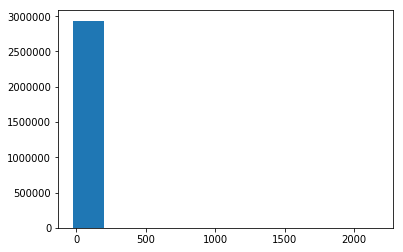

In [21]:
plt.hist(sales_train['item_cnt_day'])

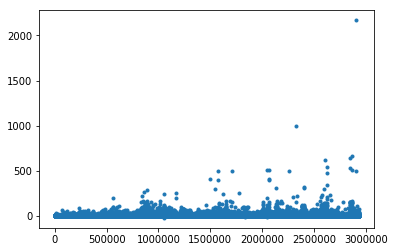

In [22]:
plt.plot(sales_train['item_cnt_day'], '.')

(array([2.935246e+06, 5.020000e+02, 5.900000e+01, 1.400000e+01,
        7.000000e+00, 2.000000e+00, 4.000000e+00, 8.000000e+00,
        2.000000e+00, 3.000000e+00]),
 array([-22. ,  47.1, 116.2, 185.3, 254.4, 323.5, 392.6, 461.7, 530.8,
        599.9, 669. ]),
 <a list of 10 Patch objects>)

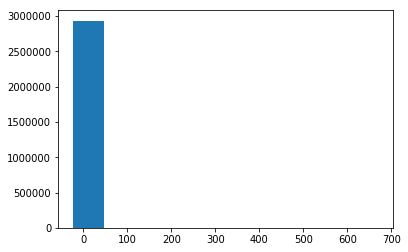

In [23]:
plt.hist(sales_train[sales_train['item_cnt_day'] < 1000]['item_cnt_day'])

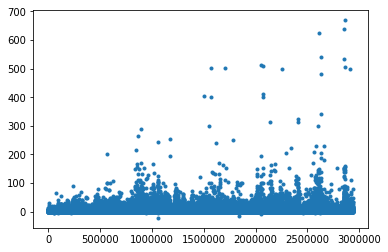

In [24]:
plt.plot(sales_train[sales_train['item_cnt_day'] < 1000]['item_cnt_day'], '.')

## Step 3: Feature preprocessing and generation with respect to models

### Delete duplicates and set date_block_num for test data

Shops with the same names, but different id
1. Якутск Орджоникидзе, 56
2. Якутск ТЦ "Центральный"
3. Жуковский ул. Чкалова 39м²

In [0]:
sales_train.loc[sales_train.shop_id == 0, 'shop_id'] = 57
sales_train.loc[sales_train.shop_id == 10, 'shop_id'] = 11
sales_train.loc[sales_train.shop_id == 1, 'shop_id'] = 58

In [0]:
test.loc[test.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [0]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

### Remove outliers

In this block, we remove the outliers that we discussed earlier, and also work with the names of the stores.

In [0]:
sales_train = sales_train[sales_train.item_price<100000]
sales_train = sales_train[sales_train.item_cnt_day<1001]

In [0]:
sales_train.loc[sales_train.item_price<0, 'item_price'] = sales_train[(sales_train.shop_id==32)&(sales_train.item_id==2973)&(sales_train.date_block_num==4)&(sales_train.item_price>0)].item_price.median()

In [0]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])

In [31]:
shops['city'].unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара',
       'СергиевПосад', 'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки',
       'Цифровой', 'Чехов', 'Якутск', 'Ярославль'], dtype=object)

In [0]:
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'

In [33]:
shops['city'].unique()

array(['Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара',
       'СергиевПосад', 'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки',
       'Цифровой', 'Чехов', 'Ярославль'], dtype=object)

LabelEncoder for features connected with shops

In [0]:
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

In [35]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [0]:
item_categories['split'] = item_categories['item_category_name'].str.split('-')
item_categories['type'] = item_categories['split'].map(lambda x: x[0].strip())
item_categories['type_code'] = LabelEncoder().fit_transform(item_categories['type'])

item_categories['subtype'] = item_categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories['subtype_code'] = LabelEncoder().fit_transform(item_categories['subtype'])
item_categories = item_categories[['item_category_id','type_code', 'subtype_code']]

In [0]:
items.drop(['item_name'], axis=1, inplace=True)

### Sales of all products for all months

The data contains only non-zero sales, but for more accurate predictions for shops, we must take into account zero sales

In [0]:
m = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = sales_train[sales_train.date_block_num==i]
    m.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))    

In [0]:
m = pd.DataFrame(np.vstack(m), columns=cols)
m['date_block_num'] = m['date_block_num'].astype(np.int8)
m['shop_id'] = m['shop_id'].astype(np.int8)
m['item_id'] = m['item_id'].astype(np.int16)
m.sort_values(cols,inplace=True)

Create total revenue for each day (shop - item)

In [0]:
sales_train['tr'] = sales_train['item_price'] *  sales_train['item_cnt_day']

### Preparation of train and test data

In [0]:
group_train = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group_train.columns = ['item_cnt_month']
group_train.reset_index(inplace=True)
m = pd.merge(m, group_train, on=cols, how='left')
m['item_cnt_month'] = (m['item_cnt_month'].fillna(0).clip(0,20).astype(np.float32))

In [0]:
m = pd.concat([m, test], ignore_index=True, sort=False, keys=cols)
m.fillna(0, inplace=True)

In [0]:
m = pd.merge(m, shops, on=['shop_id'], how='left')
m = pd.merge(m, items, on=['item_id'], how='left')
m = pd.merge(m, item_categories, on=['item_category_id'], how='left')

In [44]:
m.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'ID',
       'city_code', 'item_category_id', 'type_code', 'subtype_code'],
      dtype='object')

In [0]:
m['city_code'] = m['city_code'].astype(np.int8)
m['item_category_id'] = m['item_category_id'].astype(np.int8)
m['type_code'] = m['type_code'].astype(np.int8)
m['subtype_code'] = m['subtype_code'].astype(np.int8)

### Lag features

In [0]:
def lag_feature(data_frame, lags, column):
    ts = data_frame[['date_block_num','shop_id','item_id',column]]
    for i in lags:
        shift = ts.copy()
        shift.columns = ['date_block_num','shop_id','item_id', column +'_lag_'+str(i)]
        shift['date_block_num'] += i
        data_frame = pd.merge(data_frame, shift, on=['date_block_num','shop_id','item_id'], how='left')
    return data_frame

In [0]:
m = lag_feature(m, [1,2,3,6,12], 'item_cnt_month')

### New feature with mean and var by grouping

In [0]:
def add_group_stats(matrix_, groupby_feats, target, enc_feat, last_periods):
    if not 'date_block_num' in groupby_feats:
        print ('date_block_num must in groupby_feats')
        return matrix_
    
    group_train = matrix_.groupby(groupby_feats)[target].sum().reset_index()
    max_lags = np.max(last_periods)
    for i in range(1,max_lags + 1):
        shifted = group_train[groupby_feats + [target]].copy(deep=True)
        shifted['date_block_num'] += i
        shifted.rename({target:target + '_lag_' + str(i)},axis=1,inplace=True)
        group_train = group_train.merge(shifted, on=groupby_feats, how='left')
    group_train.fillna(0, inplace = True)
    for period in last_periods:
        lag_feats = [target + '_lag_'+str(lag) for lag in np.arange(1, period + 1)]        
        mean = group_train[lag_feats].sum(axis = 1)/float(period)
        mean2 = (group_train[lag_feats]**2).sum(axis = 1)/float(period)
        group_train[enc_feat + '_avg_sale_last_' + str(period)] = mean
        group_train[enc_feat + '_std_sale_last_' + str(period)] = (mean2 - mean**2).apply(np.sqrt)
        group_train[enc_feat + '_std_sale_last_' + str(period)].replace(np.inf,0,inplace=True)
        group_train[enc_feat + '_avg_sale_last_' + str(period)] /= group_train[enc_feat + '_avg_sale_last_' + str(period)].mean()
        group_train[enc_feat + '_std_sale_last_' + str(period)] /= group_train[enc_feat+'_std_sale_last_'+str(period)].mean()
    cols = groupby_feats + [f_ for f_ in group_train.columns.values if f_.find('_sale_last_') >= 0]
    m = matrix_.merge(group_train[cols], on=groupby_feats, how='left')
    return m

In [0]:
m = add_group_stats(m, ['date_block_num', 'item_id'], 'item_cnt_month', 'item', [6,12])
m = add_group_stats(m, ['date_block_num', 'shop_id'], 'item_cnt_month', 'shop', [6,12])
m = add_group_stats(m, ['date_block_num', 'item_category_id'], 'item_cnt_month', 'category', [12])
m = add_group_stats(m, ['date_block_num', 'city_code'], 'item_cnt_month', 'city', [12])
m = add_group_stats(m, ['date_block_num', 'type_code'], 'item_cnt_month', 'type', [12])
m = add_group_stats(m, ['date_block_num', 'subtype_code'], 'item_cnt_month', 'subtype', [12])

### Target encoding for lag features

In [0]:
def target_encoding(matrix_, groupby_feats, target, enc_feat, lags):
    group = matrix_.groupby(groupby_feats).agg({target:'mean'})
    group.columns = [enc_feat]
    group.reset_index(inplace=True)
    m = matrix_.merge(group, on=groupby_feats, how='left')
    m[enc_feat] = m[enc_feat].astype(np.float16)
    m = lag_feature(m, lags, enc_feat)
    m.drop(enc_feat, axis=1, inplace=True)
    return m

In [0]:
m = target_encoding(m, ['date_block_num'], 'item_cnt_month', 'date_avg_item_cnt', [1])
m = target_encoding(m, ['date_block_num', 'item_id'], 'item_cnt_month', 'date_item_avg_item_cnt', [1,2,3,6,12])
m = target_encoding(m, ['date_block_num', 'shop_id'], 'item_cnt_month', 'date_shop_avg_item_cnt', [1,2,3,6,12])
m = target_encoding(m, ['date_block_num', 'item_category_id'], 'item_cnt_month', 'date_cat_avg_item_cnt', [1])
m = target_encoding(m, ['date_block_num', 'shop_id', 'item_category_id'], 'item_cnt_month', 'date_shop_cat_avg_item_cnt', [1])
m = target_encoding(m, ['date_block_num', 'city_code'], 'item_cnt_month', 'date_city_avg_item_cnt', [1])
m = target_encoding(m, ['date_block_num', 'item_id', 'city_code'], 'item_cnt_month', 'date_item_city_avg_item_cnt', [1])

### Features with sales trends

Trends are important as they help us better understand long-term sales behavior and make more accurate predictions.

In [0]:
group_train = sales_train.groupby(['item_id']).agg({'item_price': ['mean']})
group_train.columns = ['item_avg_item_price']
group_train.reset_index(inplace=True)

In [0]:
m = pd.merge(m, group_train, on=['item_id'], how='left')
m['item_avg_item_price'] = m['item_avg_item_price'].astype(np.float16)

In [0]:
group_train = sales_train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group_train.columns = ['date_item_avg_item_price']
group_train.reset_index(inplace=True)

In [0]:
m = pd.merge(m, group_train, on=['date_block_num','item_id'], how='left')
m['date_item_avg_item_price'] = m['date_item_avg_item_price'].astype(np.float16)

In [0]:
l = [1,2,3,4,5,6]
m = lag_feature(m, l, 'date_item_avg_item_price')

In [0]:
for i in l:  
    m['delta_price_lag_' + str(i)] = \
        (m['date_item_avg_item_price_lag_' + str(i)] - m['item_avg_item_price']) / m['item_avg_item_price']

In [0]:
def select_trend(row):
    for i in l:
        if row['delta_price_lag_' + str(i)]:
            return row['delta_price_lag_' + str(i)]
    return 0

In [0]:
m['delta_price_lag'] = m.apply(select_trend, axis=1)
m['delta_price_lag'] = m['delta_price_lag'].astype(np.float16)
m['delta_price_lag'].fillna(0, inplace=True)

In [0]:
drop_features = ['item_avg_item_price', 'date_item_avg_item_price']
for i in l:
    drop_features += ['date_item_avg_item_price_lag_' + str(i)]
    drop_features += ['delta_price_lag_' + str(i)]

In [0]:
m.drop(drop_features, axis=1, inplace=True)

In [0]:
group_train = sales_train.groupby(['date_block_num','shop_id']).agg({'tr': ['sum']})
group_train.columns = ['date_shop_revenue']
group_train.reset_index(inplace=True)

In [0]:
m = pd.merge(m, group_train, on=['date_block_num','shop_id'], how='left')
m['date_shop_revenue'] = m['date_shop_revenue'].astype(np.float32)

In [0]:
group_train = group_train.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group_train.columns = ['shop_avg_revenue']
group_train.reset_index(inplace=True)

In [0]:
m = pd.merge(m, group_train, on=['shop_id'], how='left')
m['shop_avg_revenue'] = m['shop_avg_revenue'].astype(np.float32)

In [0]:
m['delta_revenue'] = (m['date_shop_revenue'] - m['shop_avg_revenue']) / m['shop_avg_revenue']
m['delta_revenue'] = m['delta_revenue'].astype(np.float16)
m = lag_feature(m, [1], 'delta_revenue')
m.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

### Month and year features

In [0]:
m['month'] = m['date_block_num'] % 12
m['year'] = (m['date_block_num'] / 12).astype(np.int8)

### Working with sales

Since sales of items in stores in some months are zero, various types of sales can be considered.

In [0]:
last = pd.DataFrame()
for month in range(1,35):    
    last_month = m.loc[(m['date_block_num']<month)&(m['item_cnt_month']>0)].groupby(['item_id','shop_id'])['date_block_num'].max()
    data_frame = pd.DataFrame({'date_block_num':np.ones([last_month.shape[0],])*month,
                       'item_id': last_month.index.get_level_values(0).values,
                       'shop_id': last_month.index.get_level_values(1).values,
                       'item_shop_last_sale': last_month.values})
    last = last.append(data_frame)
last['date_block_num'] = last['date_block_num'].astype(np.int8)

m = m.merge(last, on=['date_block_num','item_id','shop_id'], how='left')

In [0]:
last = pd.DataFrame()
for month in range(1,35):    
    last_month = m.loc[(m['date_block_num']<month)&(m['item_cnt_month']>0)].groupby('item_id')['date_block_num'].max()
    data_frame = pd.DataFrame({'date_block_num':np.ones([last_month.shape[0],]) * month,
                       'item_id': last_month.index.values,
                       'item_last_sale': last_month.values})
    last = last.append(data_frame)
last['date_block_num'] = last['date_block_num'].astype(np.int8)

m = m.merge(last, on=['date_block_num','item_id'], how='left')

In [0]:
m['item_shop_first_sale'] = m['date_block_num'] - m.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
m['item_first_sale'] = m['date_block_num'] - m.groupby('item_id')['date_block_num'].transform('min')

Drop some rows because of using them in lags

In [78]:
m = m[m.date_block_num > 11]
m.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'ID',
       'city_code', 'item_category_id', 'type_code', 'subtype_code',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12', 'item_avg_sale_last_6',
       'item_std_sale_last_6', 'item_avg_sale_last_12',
       'item_std_sale_last_12', 'shop_avg_sale_last_6', 'shop_std_sale_last_6',
       'shop_avg_sale_last_12', 'shop_std_sale_last_12',
       'category_avg_sale_last_12', 'category_std_sale_last_12',
       'city_avg_sale_last_12', 'city_std_sale_last_12',
       'type_avg_sale_last_12', 'type_std_sale_last_12',
       'subtype_avg_sale_last_12', 'subtype_std_sale_last_12',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_ite

In [0]:
m.to_pickle('sales_data.pkl')

### Advanced features 

Due to the too long processing time of the program, it was not possible to include some other features in this solution. It would be interesting to work with the text and compare the vectors of the names of categories, shops or items, this could improve the model, since the similarity of these vectors could affect the sales ratio. Also, identifying the closest neighbors of a particular sales facility would probably help to improve the result.

## Step 3: Fitting models and predictions

### Import some necessary libraries and delete some data

In [0]:
#import numpy as np
#import pandas as pd
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import 

In [85]:
m.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'ID',
       'city_code', 'item_category_id', 'type_code', 'subtype_code',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12', 'item_avg_sale_last_6',
       'item_std_sale_last_6', 'item_avg_sale_last_12',
       'item_std_sale_last_12', 'shop_avg_sale_last_6', 'shop_std_sale_last_6',
       'shop_avg_sale_last_12', 'shop_std_sale_last_12',
       'category_avg_sale_last_12', 'category_std_sale_last_12',
       'city_avg_sale_last_12', 'city_std_sale_last_12',
       'type_avg_sale_last_12', 'type_std_sale_last_12',
       'subtype_avg_sale_last_12', 'subtype_std_sale_last_12',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_ite

In [0]:
del group_train
del items
del shops
del item_categories
del sales_train

### XGBRegressor 

In [0]:
m1 = m[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code','subtype_code',
    'item_cnt_month_lag_1','item_cnt_month_lag_2','item_cnt_month_lag_3','item_cnt_month_lag_6','item_cnt_month_lag_12',
    'item_avg_sale_last_6', 'item_std_sale_last_6',
    'item_avg_sale_last_12', 'item_std_sale_last_12',
    'shop_avg_sale_last_6', 'shop_std_sale_last_6',
    'shop_avg_sale_last_12', 'shop_std_sale_last_12',
    'category_avg_sale_last_12', 'category_std_sale_last_12',
    'city_avg_sale_last_12', 'city_std_sale_last_12',
    'type_avg_sale_last_12', 'type_std_sale_last_12',
    'subtype_avg_sale_last_12', 'subtype_std_sale_last_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1','date_item_avg_item_cnt_lag_2','date_item_avg_item_cnt_lag_3','date_item_avg_item_cnt_lag_6','date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1','date_shop_avg_item_cnt_lag_2','date_shop_avg_item_cnt_lag_3','date_shop_avg_item_cnt_lag_6','date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month','year',
    'item_shop_last_sale','item_last_sale',
    'item_shop_first_sale','item_first_sale',
]]

In [0]:
X_train = m1[m1.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = m1[m1.date_block_num < 33]['item_cnt_month']
X_validation = m1[m1.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_validation = m1[m1.date_block_num == 33]['item_cnt_month']
X_test = m1[m1.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [0]:
xgb = XGBRegressor(max_depth=7, n_estimators=1000, min_child_weight=300, colsample_bytree=0.8, subsample=0.8, gamma = 0.005, eta=0.1, seed=42)

In [92]:
xgb.fit(X_train, Y_train, eval_metric="rmse", eval_set=[(X_train, Y_train), (X_validation, Y_validation)], verbose=10, early_stopping_rounds = 40)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:20:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:20:14] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.12498	validation_1-rmse:1.12012
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 40 rounds.
[10]	validation_0-rmse:0.891405	validation_1-rmse:0.944362
[20]	validation_0-rmse:0.845485	validation_1-rmse:0.911453
[30]	validation_0-rmse:0.831839	validation_1-rmse:0.906301
[40]	validation_0-rmse:0.823181	validation_1-rmse:0.904444
[50]	validation_0-rmse:0.817467	validation_1-rmse:0.902418
[60]	validation_0-rmse:0.812704	validation_1-rmse:0.901277
[70]	validation_0-rmse:0.808247	validation_1-rmse:0.898871
[80]	validation_0-rmse:0.803801

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0.005,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=300, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=None, subsample=0.8, verbosity=1)

In [0]:
y_pred = xgb.predict(X_validation).clip(0, 20)
y_test = xgb.predict(X_test).clip(0, 20)

X_train_2 = pd.DataFrame({"ID": np.arange(y_pred.shape[0]), "item_cnt_month": y_pred})
X_train_2.to_csv('xgb_result.csv', index=False)

submission = pd.DataFrame({"ID": np.arange(y_test.shape[0]), "item_cnt_month": y_test})
submission.to_csv('submission_xgb.csv', index=False)

In [95]:
from sklearn.externals import joblib 
joblib.dump(xgb, 'xgb.pkl') 


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['xgb.pkl']

### LGBMRegressor

In [0]:
m2 = m[[
    'date_block_num',
    'shop_id',    
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code','subtype_code',
    'item_cnt_month_lag_1','item_cnt_month_lag_2','item_cnt_month_lag_3','item_cnt_month_lag_6','item_cnt_month_lag_12',
    'item_avg_sale_last_6', 'item_std_sale_last_6',
    'item_avg_sale_last_12', 'item_std_sale_last_12',
    'shop_avg_sale_last_6', 'shop_std_sale_last_6',
    'shop_avg_sale_last_12', 'shop_std_sale_last_12',
    'category_avg_sale_last_12', 'category_std_sale_last_12',
    'city_avg_sale_last_12', 'city_std_sale_last_12',
    'type_avg_sale_last_12', 'type_std_sale_last_12',
    'subtype_avg_sale_last_12', 'subtype_std_sale_last_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1','date_item_avg_item_cnt_lag_2','date_item_avg_item_cnt_lag_3','date_item_avg_item_cnt_lag_6','date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1','date_shop_avg_item_cnt_lag_2','date_shop_avg_item_cnt_lag_3','date_shop_avg_item_cnt_lag_6','date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month','year',
    'item_shop_last_sale','item_last_sale',
    'item_shop_first_sale','item_first_sale',
]]

categorical_features = ['shop_id','city_code','item_category_id','type_code','subtype_code']

In [0]:
X_train = m2[m2.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = m2[m2.date_block_num < 33]['item_cnt_month']
X_validation = m2[m2.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_validation = m2[m2.date_block_num == 33]['item_cnt_month']
X_test = m2[m2.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [0]:
model = LGBMRegressor(max_depth = 8, n_estimators = 500, colsample_bytree=0.7, min_child_weight = 300, reg_alpha = 0.1, reg_lambda = 1, random_state = 42)

In [102]:
model.fit(X_train, Y_train, eval_metric="rmse", eval_set=[(X_train, Y_train), (X_validation, Y_validation)], verbose=10, early_stopping_rounds = 40, categorical_feature = categorical_features) 

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['city_code', 'item_category_id', 'shop_id', 'subtype_code', 'type_code']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 40 rounds.
[10]	training's rmse: 0.914915	training's l2: 0.837069	valid_1's rmse: 0.938257	valid_1's l2: 0.880326
[20]	training's rmse: 0.854046	training's l2: 0.729395	valid_1's rmse: 0.900808	valid_1's l2: 0.811455
[30]	training's rmse: 0.833372	training's l2: 0.694509	valid_1's rmse: 0.893426	valid_1's l2: 0.79821
[40]	training's rmse: 0.823877	training's l2: 0.678774	valid_1's rmse: 0.891299	valid_1's l2: 0.794414
[50]	training's rmse: 0.817065	training's l2: 0.667596	valid_1's rmse: 0.891912	valid_1's l2: 0.795507
[60]	training's rmse: 0.81235	training's l2: 0.659913	valid_1's rmse: 0.890982	valid_1's l2: 0.79385
[70]	training's rmse: 0.808223	training's l2: 0.653224	valid_1's rmse: 0.892136	valid_1's l2: 0.795906
[80]	training's rmse: 0.804514	training's l2: 0.647243	valid_1's rmse: 0.892472	valid_1's l2: 0.796506
[90]	training's rmse: 0.80169	training's l2: 0.642707	valid_1's rmse: 0.892535	valid_1's l2: 0.796619
[100]	training'

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
              importance_type='split', learning_rate=0.1, max_depth=8,
              min_child_samples=20, min_child_weight=300, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.1, reg_lambda=1, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
y_pred_l = model.predict(X_validation).clip(0, 20)
y_test_l = model.predict(X_test).clip(0, 20)

X_train_2_l = pd.DataFrame({"ID": np.arange(y_pred.shape[0]), "item_cnt_month": y_pred_l})
X_train_2_l.to_csv('lightgbm_result.csv', index=False)

submission = pd.DataFrame({"ID": np.arange(y_test_l.shape[0]), "item_cnt_month": y_test_l})
submission.to_csv('submission_lightgbm.csv', index=False)

In [116]:
joblib.dump(model, 'lightgbm.pkl') 

['lightgbm.pkl']

## Step 4: Ensemblings

### Averaging

Find average of two models to make better predictions

In [0]:
y_test_av = (y_test + y_test_l)/2
submission = pd.DataFrame({"ID": np.arange(y_test.shape[0]), "item_cnt_month": y_test_av})
submission.to_csv('submission_lightgbm_xgb_average.csv', index=False)

### Linear Regression for two models

If one model has more weight and the other less, we can achieve better results.

In [0]:
X_train_level2 = pd.DataFrame()

In [0]:
df_lightgbm = pd.read_csv('lightgbm_result.csv')

In [0]:
df_xgb = pd.read_csv('xgb_result.csv')

In [0]:
X_train_level2['lgb'] = df_lightgbm['item_cnt_month']
X_train_level2['xgb'] = df_xgb['item_cnt_month']

In [0]:
X_test_level2 = pd.DataFrame()

In [0]:
df_lightgbm_test = pd.read_csv('submission_lightgbm.csv')
df_xgb_test = pd.read_csv('submission_xgb.csv')

In [0]:
X_test_level2['lgb'] = df_lightgbm_test['item_cnt_month']
X_test_level2['xgb'] = df_xgb_test['item_cnt_month'] 

In [0]:
Y_train_level2 = m2[m2.date_block_num == 33]['item_cnt_month']

In [129]:
X_test_level2.shape

(214200, 2)

In [130]:
X_train_level2.shape

(238172, 2)

In [0]:
lr_level2 = LinearRegression()
lr_level2.fit(X_train_level2, Y_train_level2)
Y_test_level2 = lr_level2.predict(X_test_level2)
submission = pd.DataFrame({"ID": np.arange(Y_test_level2.shape[0]), "item_cnt_month": Y_test_level2})
submission.to_csv('lr_with_xgb_and_lightgbm.csv', index=False)

### Ridge with hyperparameter tuning (alpha) for two models

In [0]:
ridge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train_level2, Y_train_level2)

In [0]:
Y_test_level2_r = ridge.predict(X_test_level2)
submission = pd.DataFrame({"ID": np.arange(Y_test_level2_r.shape[0]), "item_cnt_month": Y_test_level2_r})
submission.to_csv('ridge_with_xgb_and_lightgbm.csv', index=False)

## Step 5: public score

1. Averaging 0.90730
2. Linear Regression for two models 0.90405
3. Ridge with hyperparameter tuning (alpha) for two models 0.90757